In [ ]:
!pip install opendatasets
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import torch
from torch import nn
import torch.optim as optim 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
from skimage.transform import resize
import cv2
import torchvision

In [ ]:
seed = 72
torch.manual_seed(seed)         
torch.cuda.manual_seed(seed)    

In [ ]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/nih-chest-xrays/data")


100%|██████████| 42.0G/42.0G [20:47<00:00, 36.2MB/s]


#☕ **Loading the dataset & preprocessing the data**

let's get the X-ray scans and the lables from the NIH dataset, analyze it and preprocess it

In [ ]:
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
34978  00009230_003.png     No Finding            3        9230           37   
78031  00019157_012.png     No Finding           12       19157           57   
74922  00018375_000.png     No Finding            0       18375           34   

      Patient Gender View Position  OriginalImage[Width  Height]  \
34978              M            AP                 3056     2544   
78031              M            PA                 2992     2991   
74922              F            PA                 2602     2991   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
34978                        0.139  0.139          NaN   
78031                        0.143  0.143          NaN   
74922                        0.143  0.143          NaN   

                                          path  
34978  data/images_004/images/00009230_003.png  
78031  data/images_009/images/00019157_012.png  
74922  data/images_008/images/00018375_000.png

##  standardizing the Patient Age
 
 as said, we would like to standardize the age such that  $\mu = 0$ , $\sigma = 1$
 but first, let's verify that the distribution even resambles a normal one:

16.839847435450604


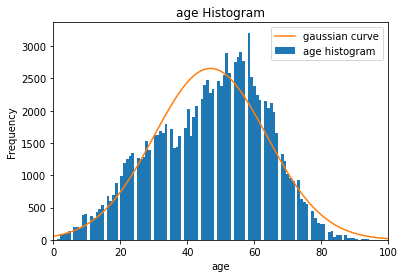

In [ ]:
mu = np.mean(all_xray_df['Patient Age'])
sigma = np.std(all_xray_df['Patient Age'])
print(sigma)


plt.hist(all_xray_df['Patient Age'], bins=500)

plt.gca().set(title='age Histogram', ylabel='Frequency',xlabel = 'age');
plt.xlim([0, 100])

x_data = np.arange(0, 100, 0.001)

## y-axis as the gaussian
y_data = stats.norm.pdf(x_data, mu, sigma)*len(all_xray_df['Patient Age'])


plt.plot(x_data,y_data)
plt.legend(["gaussian curve","age histogram"])

seems pretty close, let us standardize it

In [ ]:
print(f'𝜇 = {mu},\t 𝜎 = {sigma}')

all_xray_df['Patient Age'] = (all_xray_df['Patient Age'])/ sigma - mu/sigma


𝜇 = 46.90146271851587,	 𝜎 = 16.839847435450604


now compute and display the new $\mu $ and $\sigma $


In [ ]:
mu = np.mean(all_xray_df['Patient Age'])
sigma = np.std(all_xray_df['Patient Age'])

print(f'𝜇 = {mu},\t 𝜎 = {sigma}')

𝜇 = 2.911374712880753e-16,	 𝜎 = 1.0


let's view the difference in our dataset

In [ ]:
all_xray_df.sample(3)


Image Index             Finding Labels  Follow-up #  Patient ID  \
54630  00013670_137.png          Infiltration|Mass          137       13670   
7627   00001996_001.png                 No Finding            1        1996   
44949  00011553_014.png  Infiltration|Pneumothorax           14       11553   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
54630     0.540298              M            AP                 2048     2500   
7627      0.065234              F            PA                 3056     2544   
44949    -2.250701              M            AP                 2048     2500   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
54630                        0.168  0.168          NaN   
7627                         0.139  0.139          NaN   
44949                        0.168  0.168          NaN   

                                          path  
54630  data/images_006/images/00013670_137.png  
7627   data/images_002/images/00001996_001.png  
44949  data/images_005/images/00011553_014.png

## Adjusting the output
Here we take the labels and make them into a more clear format. what's most important for us right now is to devide our label values into 2: cardiomegali diagnosed or "No finding".

In [ ]:
all_xray_df['Finding Labels'] = [x.split("|") for x in all_xray_df['Finding Labels']]


In [ ]:
all_xray_df['Cardiomegaly'] = [('Cardiomegaly' in x)*1 for x in all_xray_df['Finding Labels']]
all_xray_df['No Finding'] = [('No Finding' in x)*1 for x in all_xray_df['Finding Labels']]

print(f"number of patients diagnosed with cardiomegaly: {np.sum(all_xray_df['Cardiomegaly'])}")
print(f"number of patients diagnosed with No Finding: {np.sum(all_xray_df['No Finding'])}")

number of patients diagnosed with cardiomegaly: 2776
number of patients diagnosed with No Finding: 60361


1
1
1
0


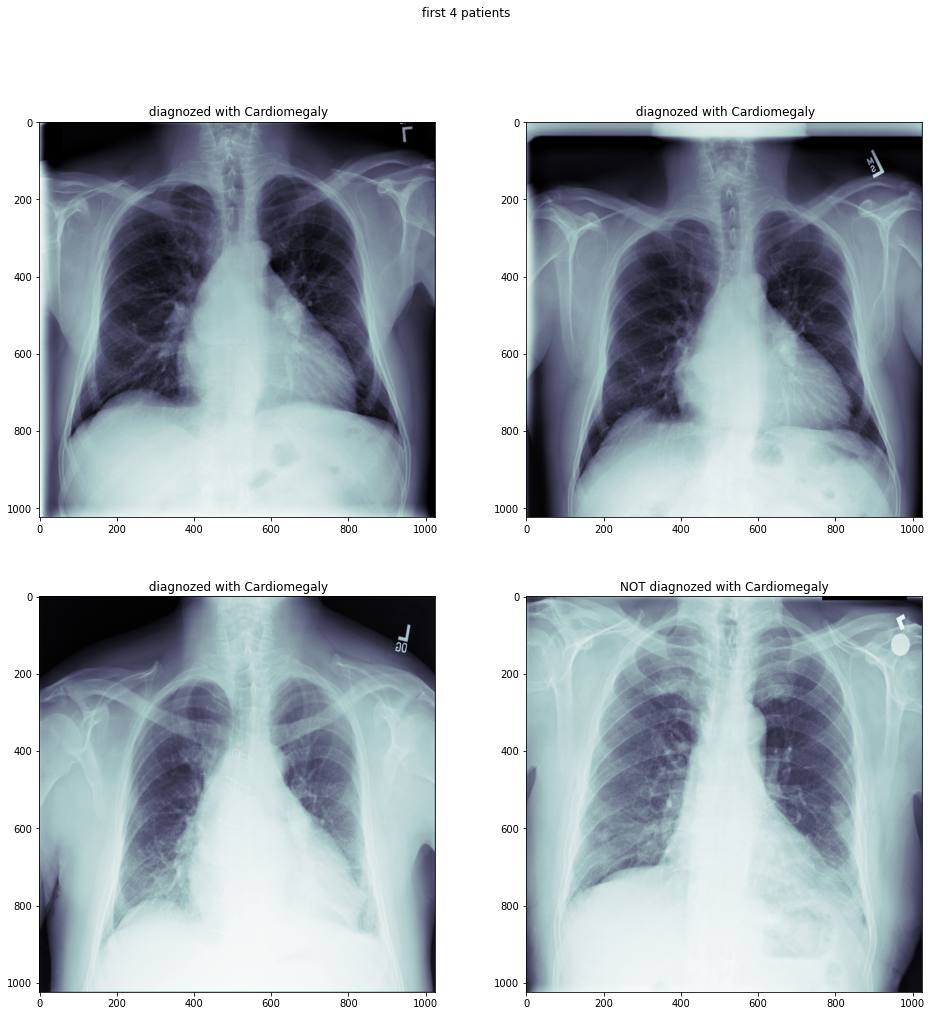

In [ ]:
with_cardio = [plt.imread(all_xray_df['path'][i]) for i in range(4)]
# plt.imshow(with_cardio,cmap = 'bone')


fig, m_axs = plt.subplots(2, 2,figsize = (16, 16))
fig.suptitle('first 4 patients')

for i, ax in enumerate(m_axs.flatten()):
    
    print(all_xray_df['Cardiomegaly'][i])
    ax.imshow(with_cardio[i],cmap = 'bone')
    ax.set_title(f"{'NOT'*(not all_xray_df['Cardiomegaly'][i])} diagnozed with Cardiomegaly")



we want to resize the image so we check the image features for (200,200)

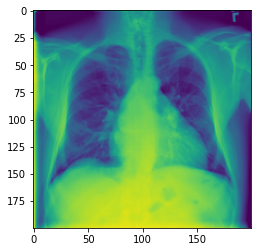

In [ ]:
img = plt.imread(all_xray_df['path'][0])
img=resize(img,(200,200))
plt.imshow(img)

In [ ]:
all_xray_df['Gender'] =  [0 if g =='M' else 1 for g in all_xray_df['Patient Gender']]
all_xray_df['position'] =  [0 if g =='AP' else 1 for g in all_xray_df['View Position']]
all_xray_df.sample(3)

Image Index        Finding Labels  Follow-up #  Patient ID  \
39164  00010270_001.png          [No Finding]            1       10270   
74293  00018249_017.png  [Pleural_Thickening]           17       18249   
81012  00019899_002.png          [No Finding]            2       19899   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
39164    -1.775637              M            PA                 2738     2833   
74293    -0.647361              M            PA                 2992     2991   
81012     1.015362              M            PA                 2992     2991   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
39164                        0.143  0.143          NaN   
74293                        0.143  0.143          NaN   
81012                        0.143  0.143          NaN   

                                          path  Cardiomegaly  No Finding  \
39164  data/images_005/images/00010270_001.png             0           1   
74293  data/images_008/images/00018249_017.png             0           0   
81012  data/images_009/images/00019899_002.png             0           1   

       Gender  position  
39164       0         1  
74293       0         1  
81012       0         1

## Building the balanced Cardiomegali dataset

*   we take positive cases and for the sake of balancing the data, we take a close amount for the negative cases.

*   as a balnce vs. dataset size trade off,  we take $ξ$ more negative cases to enlarge the total size. 



In [ ]:
mask = all_xray_df['Cardiomegaly'] == 1
positive = all_xray_df.loc[mask]
positive = positive.reset_index(drop=True)

neg_mask = all_xray_df['No Finding'] == 1
negative = all_xray_df.loc[neg_mask]
negative = negative.sample(frac=1).reset_index(drop=True)

#chosen_idx = np.random.choice(len(negative), replace = False, size = int(n*1.2))




## Split the Data to Train, Valid and Test



*   positive - "cardiomegaly"

*   negative - "No findings"




In [ ]:
TRAINSIZE = 0.86
VALSIZE = 0.93


p =len(positive)
n = len(negative)
N = n+p


data = pd.concat([positive,negative]).sample(frac=1).reset_index(drop=True)


pos_train, pos_test, pos_val = positive.iloc[:int(TRAINSIZE*p)], positive.iloc[int(TRAINSIZE*p):int(VALSIZE*p)],positive.iloc[int(VALSIZE*p):]
neg_train, neg_test, neg_val = negative.iloc[:int(TRAINSIZE*n)], negative.iloc[int(TRAINSIZE*n):int(VALSIZE*n)],negative.iloc[int(VALSIZE*n):n]
data_train, data_test, data_val = data.iloc[:int(TRAINSIZE*N)], data.iloc[int(TRAINSIZE*N):int(VALSIZE*N)],data.iloc[int(VALSIZE*N):]

data_train = data_train.reset_index(drop=True)
pos_train = pos_train.reset_index(drop=True)
neg_train = neg_train.reset_index(drop=True)

data_test = data_test.reset_index(drop=True)
pos_test = pos_test.reset_index(drop=True)
neg_test = neg_test.reset_index(drop=True)

data_val = data_val.reset_index(drop=True)
pos_val = pos_val.reset_index(drop=True)
neg_val = neg_val.reset_index(drop=True)
pos_val


Image Index                                     Finding Labels  \
0    00028526_003.png                           [Cardiomegaly, Effusion]   
1    00028526_009.png                                     [Cardiomegaly]   
2    00028526_015.png                    [Cardiomegaly, Edema, Effusion]   
3    00028526_016.png                       [Cardiomegaly, Infiltration]   
4    00028534_001.png                                     [Cardiomegaly]   
..                ...                                                ...   
190  00030764_000.png                                     [Cardiomegaly]   
191  00030786_002.png  [Cardiomegaly, Effusion, Emphysema, Pneumothorax]   
192  00030786_003.png  [Cardiomegaly, Effusion, Emphysema, Pneumothorax]   
193  00030786_004.png  [Cardiomegaly, Effusion, Emphysema, Pneumothorax]   
194  00030786_005.png                [Cardiomegaly, Effusion, Emphysema]   

     Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
0              3       28526    -0.766127              M            AP   
1              9       28526    -0.766127              M            AP   
2             15       28526    -0.766127              M            AP   
3             16       28526    -0.766127              M            AP   
4              1       28534     0.955979              F            PA   
..           ...         ...          ...            ...           ...   
190            0       30764    -0.647361              M            PA   
191            2       30786     0.837213              F            AP   
192            3       30786     0.837213              F            AP   
193            4       30786     0.837213              F            AP   
194            5       30786     0.837213              F            AP   

     OriginalImage[Width  Height]  OriginalImagePixelSpacing[x        y]  \
0                   3056     2544                     0.139000  0.139000   
1                   3056     2544                     0.139000  0.139000   
2                   3056     2544                     0.139000  0.139000   
3                   2544     3056                     0.139000  0.139000   
4                   2021     2021                     0.194311  0.194311   
..                   ...      ...                          ...       ...   
190                 2021     2021                     0.194311  0.194311   
191                 3056     2544                     0.139000  0.139000   
192                 3056     2544                     0.139000  0.139000   
193                 3056     2544                     0.139000  0.139000   
194                 3056     2544                     0.139000  0.139000   

     Unnamed: 11                                     path  Cardiomegaly  \
0            NaN  data/images_012/images/00028526_003.png             1   
1            NaN  data/images_012/images/00028526_009.png             1   
2            NaN  data/images_012/images/00028526_015.png             1   
3            NaN  data/images_012/images/00028526_016.png             1   
4            NaN  data/images_012/images/00028534_001.png             1   
..           ...                                      ...           ...   
190          NaN  data/images_012/images/00030764_000.png             1   
191          NaN  data/images_012/images/00030786_002.png             1   
192          NaN  data/images_012/images/00030786_003.png             1   
193          NaN  data/images_012/images/00030786_004.png             1   
194          NaN  data/images_012/images/00030786_005.png             1   

     No Finding  Gender  position  
0             0       0         0  
1             0       0         0  
2             0       0         0  
3             0       0         0  
4             0       1         1  
..          ...     ...       ...  
190           0       0         1  
191           0       1         0  
192           0       1         0  
193           0       1         0 

## Transforming the Dataset to Tensors

Our data is stored in collabs hard disc what cause high runtime, we will write a function that will store the train, val, test images in tensors.

In [ ]:
def collect_tensor(data,H,W):
  n=len(data)
  data_array = torch.zeros((n,H,W))
  variables = torch.zeros((n,3))

  for j in range(n):
    if plt.imread(data['path'][j]).shape==(1024,1024):
      data_array[j] = torch.tensor(resize(plt.imread(data['path'][j])[144:960,80:960],(H,W)))   
    else:
      data_array[j] = torch.tensor(resize(plt.imread(data['path'][j])[144:960,80:960,0],(H,W)))
    
    
    variables[j,0] = data['Patient Age'][j]
    variables[j,1] = data['Gender'][j]
    variables[j,2] = data['position'][j]

  return data_array, variables
     


In [ ]:
H=224
W=224

pos_train_arr , vars_pos_train_arr = collect_tensor(pos_train,H,W)

pos_test_arr , vars_pos_test_arr = collect_tensor(pos_test,H,W)

pos_val_arr  , vars_pos_val_arr = collect_tensor(pos_val,H,W)

neg_train_arr  , vars_neg_train_arr = collect_tensor(neg_train[:2500],H,W)

neg_test_arr ,vars_neg_test_arr = collect_tensor(neg_test[:300],H,W)

neg_val_arr  ,vars_neg_val_arr = collect_tensor(neg_val[:300],H,W)


For testing the data we will try to look for different crops for the image, and different resizes to decide what transformation our good for the data.

<ipython-input-18-6ce3c7601229>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


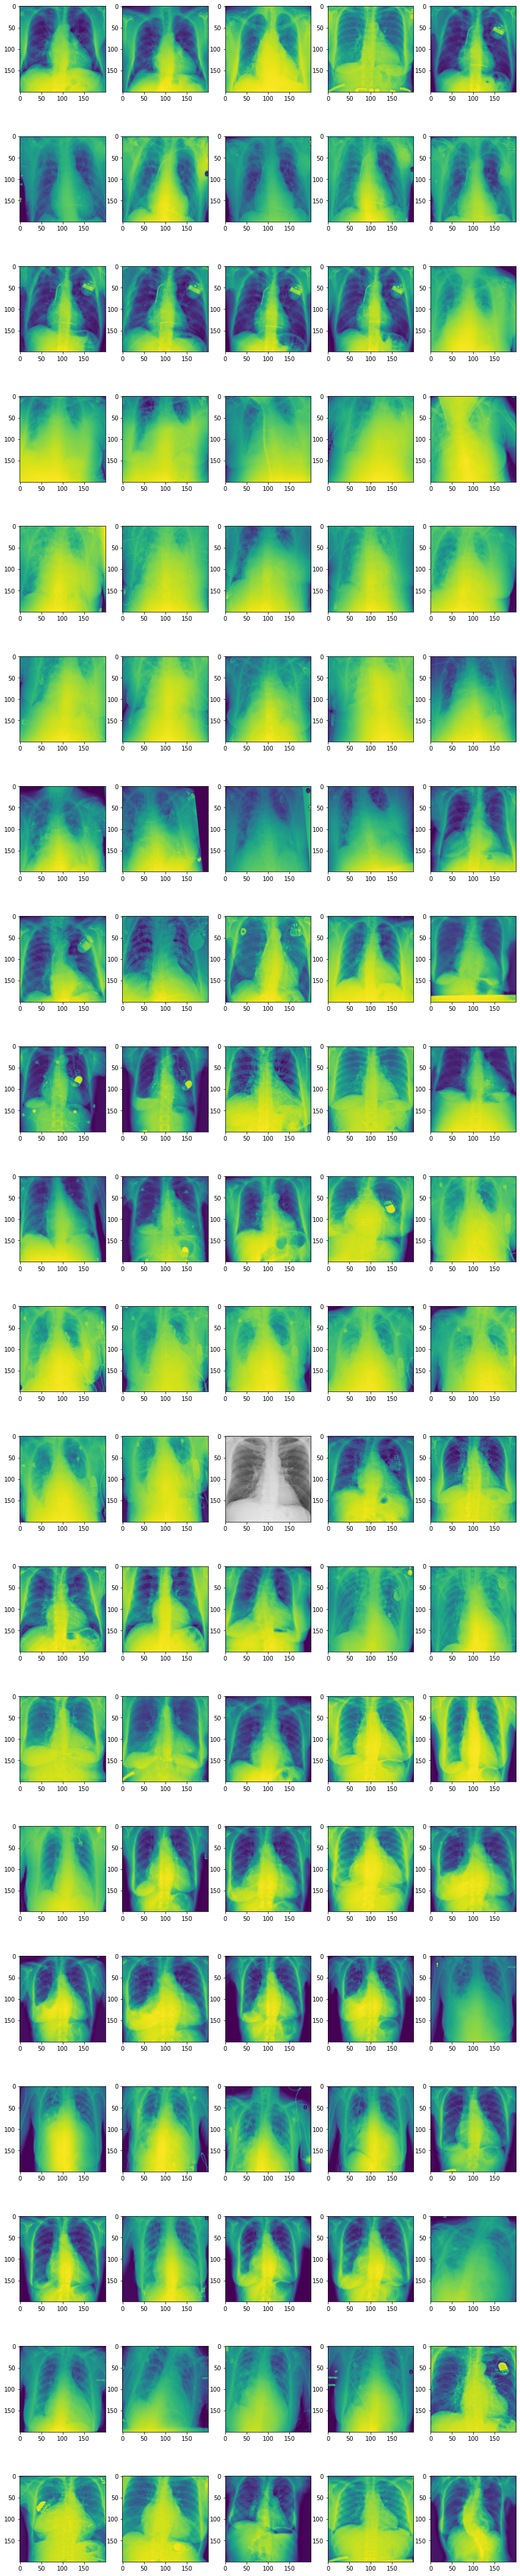

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
m, n =20, 5 
fig, axs = plt.subplots(m, n, figsize= (n*3,m*4))
for i in range(100):
  plt.figure()
  axs[i//n,i%n].imshow(resize(plt.imread(pos_train['path'][i])[144:960,80:960],(200,200)))

  

In [ ]:
a = cv2.cvtColor(resize(plt.imread(pos_train['path'][0])[144:960,80:960],(200,200)),cv2.COLOR_GRAY2BGR)

[[0.33830032 0.34175277 0.3533331  ... 0.42291254 0.42212188 0.42259067]
 [0.34982288 0.3491196  0.3604847  ... 0.43393573 0.4391163  0.44971403]
 [0.40655118 0.40295398 0.4108998  ... 0.48449203 0.50362885 0.5173724 ]
 ...
 [0.5845965  0.595785   0.61930186 ... 0.562861   0.52222013 0.4694783 ]
 [0.5795193  0.5934201  0.61601746 ... 0.57087106 0.5169892  0.4562456 ]
 [0.5729065  0.59580594 0.61413723 ... 0.57199025 0.50950843 0.4517095 ]] 

[[0.33830032 0.34175277 0.3533331  ... 0.42291254 0.42212188 0.42259067]
 [0.34982288 0.3491196  0.3604847  ... 0.43393573 0.4391163  0.44971403]
 [0.40655118 0.40295398 0.4108998  ... 0.48449203 0.50362885 0.5173724 ]
 ...
 [0.5845965  0.595785   0.61930186 ... 0.562861   0.52222013 0.4694783 ]
 [0.5795193  0.5934201  0.61601746 ... 0.57087106 0.5169892  0.4562456 ]
 [0.5729065  0.59580594 0.61413723 ... 0.57199025 0.50950843 0.4517095 ]] 

[[0.33830032 0.34175277 0.3533331  ... 0.42291254 0.42212188 0.42259067]
 [0.34982288 0.3491196  0.3604847  

## ????

We will write a function which will generate positive/negative tensor batches for the accuracy check function.

In [ ]:
def generate_batch_tensor(data):
   n=len(data)
   xt = torch.zeros((n,224,224))
   vars = torch.zeros((n,3))
   for j in range(n):  
      xt[j]=data[j]
      #vars[j][0]=data[j][1]
      #vars[j][1]=data[j][2]
      #vars[j][2]=data[j][3]
      
   xt=xt.reshape(n,224,224,1)
   xt=torch.cat((xt,xt,xt),3)
   xt=xt.reshape(n,3,224,224)
   

   return xt,vars          
  


vectorizing the gender column

### bold text **TODO** we need to figure out how to demonstrate / prove correlation between gender and cardio.

if there is none, remove the column 

In [ ]:
fu_mean = np.mean(all_xray_df['Follow-up #'])
fu_mean_cardio = np.mean(all_xray_df.loc[all_xray_df['Cardiomegaly'] == True]['Follow-up #'])

print(f'followup mean in dataset:{fu_mean}\nfollowup mean for diagnosed patients:{fu_mean_cardio}\n')

followup mean in dataset:8.5737513378523
followup mean for diagnosed patients:10.95028818443804



input size: $224 𝗑 224$




# 🕸 **Network architecture**

Now we will build the architecture of the model.

important to mention that we used some image shapes: 1024X1024, 880X816, 200X200.

**BLOCK 1:**



*   Convolutional layer (nn.Conv2D(in_channels, num_hidden,kernel_size=(3,3), stride=(2,2)))

*   Batch Normalization(num_hidden)




*   MaxPool2d(kernel_size=2, stride=2))

*   Activation Function: nn.ReLU()







**BLOCK 2:**






*   Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))

*   Activation Function: nn.ReLU()

*   Batch Normalization(num_hidden * 2)
*   MaxPool2d(kernel_size=2, stride=2))



**BLOCK 3:**


*   Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))

*   Activation Function: nn.ReLU()

*   Batch Normalization(num_hidden * 4)


 
**BLOCK 4:**


*   Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))

*   Activation Function: nn.ReLU()



*   Batch Normalization(num_hidden * 8)











**BLOCK 5:**


*   FC layer(3 * 3 * 8 * num_hiddens,100)

*   Activation Function: nn.Sigmoid()

*   FC layer(100,20)

*   Activation Function: nn.Sigmoid())




**BLOCK 6:**

In this chapter we add the arguments: [Age,Gender,angle]
                           

*   FC layer(20 + num_vars, 2)
*   nn.Sigmoid()





In [ ]:

class CNN(nn.Module):
    def __init__(self, num_hiddens,num_vars):

        
        super(CNN, self).__init__()

        self.H = 224
        self.W = 224
        in_channels = 1
        self.num_hiddens = num_hiddens
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.block2 = nn.Sequential(nn.Conv2d(num_hiddens, num_hiddens*2, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*2),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.block3 = nn.Sequential(nn.Conv2d(num_hiddens*2, num_hiddens*4, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*4))
        
        self.block4 = nn.Sequential(nn.Conv2d(num_hiddens*4, num_hiddens*8, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*8))


        self.fc_block1 = nn.Sequential(nn.Linear(3*3*8*num_hiddens,100), #flatten the CNN output
                                       nn.Sigmoid(),
                                       nn.Linear(100,20),
                                       nn.Sigmoid())
        
        self.fc_block2 =  nn.Sequential(nn.Linear(20 + num_vars, 2), #flatten the CNN output
                                       nn.Sigmoid())
        

    def forward(self,x,vars):
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.contiguous().view(-1,3*3*8*self.num_hiddens) # reshape for tensor
        
        x = self.fc_block1(x)
        #x= torch.cat((x,vars),1)
        x = self.fc_block2(x)

        return x


In [ ]:
model= CNN(3,2)
model.forward(lst_train[0])

NameError: ignored

## **Evaluation function**

We will test the accuracy of the positive and negative separately.



In [ ]:
path_saving  = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio'

In [ ]:
def get_accuracy(model, pos,neg,batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """
    len_pos= len(pos)
    len_neg=len(neg)
    model.eval()
    acc_pos=0
    acc_neg=0
    H=224
    W=224
      
    pos_correct = 0
    for i in range(0, len_pos, batch_size):
        if (i+batch_size)>len_pos:
          break
        acc_pos += batch_size
        xs , var_xs = generate_batch_tensor(pos[i:i+batch_size])
        if torch.cuda.is_available():
            xs , var_xs = xs.cuda() , var_xs.cuda()
        #zs = model(xs,var_xs)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len_pos, batch_size):
        if (i+batch_size)>len_pos:
            break
        acc_neg += batch_size
        xs , var_xs = generate_batch_tensor(neg[i:i+batch_size])
        if torch.cuda.is_available():
            xs , var_xs = xs.cuda() , var_xs.cuda()
        #zs = model(xs,var_xs)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct/acc_pos, neg_correct/acc_neg

## **Training function**

While training the different models we had to modify the training function multiple times.



In [ ]:
def nn_train(model,
              p_train = pos_train_arr,
              n_train = neg_train_arr,
              p_val = pos_val_arr,
              n_val = neg_val_arr,
              batch_size=10,
              learning_rate=0.001,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=None,
              vars = False
              ):
#main training loop; choice of loss function; choice of optimizer
  #print("hi")

 
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.cuda()
  
  
  optimizer = optim.SGD(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay,
                           momentum=0.9)
  
  iters, losses = [], []
  iters_sub, train_accs_pos , train_accs_neg, val_accs_pos, val_accs_neg  = [], [] ,[],[],[]
  #print("hi2")
  
  len_data= min(len(p_train),len(n_train))
  acc_len_pos=0
  acc_len_neg=0
  H=224
  W=224
  n = 1501 # the number of iterations
  while n < max_iters:
      for i in range(0, len_data, batch_size):
            if (i + batch_size) > len_data:
                break
            
            model.train()
            
            #in each iteration, take batch_size / 2 positive samples and batch_size / 2 negative samples as our input for this batch
            #pos_st,neg_st = np.ones(batch_size / 2), np.zeros(batch_size / 2)

            xt=torch.zeros((2*batch_size,H,W))  #define empty tensor for batch
            pos_st,neg_st = np.ones((batch_size)), np.zeros((batch_size))  #define batch//2 positive and batch//2 negative
            st = np.concatenate((pos_st,neg_st),axis=0)
            st = np.random.permutation(st)  #permutate the positive and negative outputs
            st_or = torch.zeros((2*batch_size,2)) #define output tensor -  negative : [1,0], positive : [0,1] 
            vars = torch.zeros((2*batch_size,3)) # define tensor for variables : [Age, gender , Angle]
            
            #building the batch input tensors
            
            pos_idx=i
            neg_idx=i
            j=-1
                     
            while( pos_idx+neg_idx<2*i+2*batch_size):  
              j+=1 
              if st[j]:
                xt[j]=p_train[pos_idx]
                st_or[j,1]=1
                #vars[j][0]=p_train[pos_idx]
                #vars[j][1]=p_train[pos_idx]
                #vars[j][2]=p_train[pos_idx]
                pos_idx+=1

              else:
                xt[j]=n_train[neg_idx]
                st_or[j,0]=1
                #vars[j][0]=n_train[neg_idx]
                #vars[j][1]=n_train[neg_idx]
                #vars[j][2]=n_train[neg_idx]
                neg_idx+=1
              
          
            
            #conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions  N×C×H×W  (known as NCHW tensor)
            #.. where  N  is the number of images batch size,  C  is the number of channels,  H  is the height of the image, and  W  is the width of the image.
            

            xt=xt.reshape(2*batch_size,H,W,1)
            xt = torch.cat((xt,xt,xt),3)  #GRAYSCALE to RGB for training the resnet18,VGG16 models
            xt=xt.reshape(2*batch_size,3,H,W)
            
    
            if torch.cuda.is_available():
                xt , vars , st = xt.cuda() , vars.cuda() , st_or.cuda()
            
            #zs = model(xt,vars)  # forwarding the model
            zs = model(xt)
            #print('zs=', zs.shape, zs)  
            optimizer.zero_grad()
            loss = criterion(zs, st)
            loss.backward()
            losses.append(float(loss)/batch_size) 
            optimizer.step()
            

            #after every epoch, report the accuracies for the training set and validation set
            if n % 100==0:
                iters_sub.append(n)
                train_cost = float(loss.detach().cpu().numpy())
                train_acc_pos,train_acc_neg  = get_accuracy(model, p_train[:300],n_train,batch_size)
                train_accs_pos.append(train_acc_pos)
                train_accs_neg.append(train_acc_neg)
                val_acc_pos , val_acc_neg = get_accuracy(model, p_val,n_val,batch_size)
                val_accs_pos.append(val_acc_pos)
                val_accs_neg.append(val_acc_neg)
                print("Iter %d. [Val pos Acc %.0f%%] [Val neg Acc %.0f%%] [Train pos Acc %.0f%%,Train neg Acc %.0f%%, Loss %f]" % (n, val_acc_pos * 100,val_acc_neg * 100, train_acc_pos * 100, train_acc_neg * 100, train_cost))

                if (n>500 and n % 400==0 and checkpoint_path is not None):  #save model
                    n_path = checkpoint_path + f"{n}"
                    torch.save(model.state_dict(), n_path.format(n))
            # increment the iteration number
            n += 1

            if n > max_iters:
              return model,losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg
        
            
            


          #track the training curve information and plot the training curve
        
              
  return model,losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg

# 💪 **Training the Model: Trial & Error**

## **Sanity check**:

we will try to memorize the data for 10 positive and 10 negative samples

In [ ]:
if torch.cuda.is_available():
  CNN_20 = CNN(3,2).cuda()
else:
  CNN_20 = CNN(3,2)

history_20 = nn_train(CNN_20,pos_train=pos_train[:20],neg_train=neg_train[:20],batch_size=10,learning_rate=0.0001,
              weight_decay=0,
              max_iters=700,
              checkpoint_path=None)

Iter 0. [Val pos Acc 27%] [Val neg Acc 68%] [Train pos Acc 25%,Train neg Acc 80%, Loss 0.693068]
Iter 100. [Val pos Acc 56%] [Val neg Acc 51%] [Train pos Acc 65%,Train neg Acc 85%, Loss 0.689899]
Iter 200. [Val pos Acc 71%] [Val neg Acc 50%] [Train pos Acc 95%,Train neg Acc 100%, Loss 0.666825]
Iter 300. [Val pos Acc 72%] [Val neg Acc 50%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.636497]
Iter 400. [Val pos Acc 69%] [Val neg Acc 53%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.612569]
Iter 500. [Val pos Acc 68%] [Val neg Acc 52%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.591701]
Iter 600. [Val pos Acc 68%] [Val neg Acc 52%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.574090]
Iter 700. [Val pos Acc 69%] [Val neg Acc 51%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.557051]


## **First training**

Now we will train the model for the first time. For curiosity, at first we train the images with 1024X1024 size to see how close the results we get.


In [ ]:
if torch.cuda.is_available():
  CNN_cardio = CNN(3,2).cuda()
else:
  CNN_cardio = CNN(3,2)
  



In [ ]:
CNN_cardio,losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg  = nn_train(CNN_cardio,batch_size=10,learning_rate=0.0001,
              weight_decay=0,
              max_iters=4000,
              checkpoint_path=path_saving+"original_")

Iter 0. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.692406]
Iter 100. [Val pos Acc 87%] [Val neg Acc 36%] [Train pos Acc 88%,Train neg Acc 38%, Loss 0.691356]
Iter 200. [Val pos Acc 89%] [Val neg Acc 43%] [Train pos Acc 91%,Train neg Acc 42%, Loss 0.684247]
Iter 300. [Val pos Acc 87%] [Val neg Acc 48%] [Train pos Acc 90%,Train neg Acc 52%, Loss 0.682697]
Iter 400. [Val pos Acc 81%] [Val neg Acc 55%] [Train pos Acc 88%,Train neg Acc 61%, Loss 0.674836]
Iter 500. [Val pos Acc 80%] [Val neg Acc 58%] [Train pos Acc 89%,Train neg Acc 71%, Loss 0.667060]
Iter 600. [Val pos Acc 78%] [Val neg Acc 58%] [Train pos Acc 90%,Train neg Acc 73%, Loss 0.669346]
Iter 700. [Val pos Acc 56%] [Val neg Acc 76%] [Train pos Acc 80%,Train neg Acc 85%, Loss 0.616175]
Iter 800. [Val pos Acc 80%] [Val neg Acc 61%] [Train pos Acc 95%,Train neg Acc 81%, Loss 0.612055]
Iter 900. [Val pos Acc 57%] [Val neg Acc 78%] [Train pos Acc 87%,Train neg Acc 87%, Loss 0.628931]
Iter 1000. [

KeyboardInterrupt: ignored

## Overcoming Overfitting
We see that we got an **overfitting** because the model memorized the training data but have a poor validation prediction. we added several munipulations to the images:
1. we see that there is some area that have no information so we cropped the images.
2. for the overfitting we added a max pooling layers to make model more robustic, and we shuffle the training data everytime it gets to an end to make it harder for the model to memorize it.

Now we will train to give our model a second try.

In [ ]:
torch.save(CNN_cardio.state_dict(), (path_saving+"cardio_10_iter").format(n))

In [ ]:
if torch.cuda.is_available():
  CNN_cardio2 = CNN(3,2).cuda()
else:
  CNN_cardio2 = CNN(3,2)

In [ ]:
if torch.cuda.is_available():
  CNN_cardio_shuffled = CNN(3,2).cuda()
else:
  CNN_cardio_shffled = CNN(3,2)
  


In [ ]:
CNN_cardio_shuffled,losses5, train_accs_pos5, train_accs_neg5, val_accs_pos5, val_accs_neg5  = nn_train(CNN_cardio_shuffled,batch_size=10,learning_rate=0.0001,
              weight_decay=0,
              max_iters=2500,
              checkpoint_path=path_saving+"_shffled")

Iter 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.698400]
Iter 100. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.696566]
Iter 200. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.694787]
Iter 300. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.693351]
Iter 400. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.691781]
Iter 500. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.691409]
Iter 600. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.690726]
Iter 700. [Val pos Acc 35%] [Val neg Acc 79%] [Train pos Acc 37%,Train neg Acc 83%, Loss 0.690854]
Iter 800. [Val pos Acc 64%] [Val neg Acc 68%] [Train pos Acc 65%,Train neg Acc 68%, Loss 0.682321]
Iter 900. [Val pos Acc 66%] [Val neg Acc 68%] [Train pos Acc 65%,Train neg Acc 69%, Loss 0.673153]
Iter 1000. [

In [ ]:
CNN_cardio_shuffled,losses6, train_accs_pos6, train_accs_neg6, val_accs_pos6, val_accs_neg6  = nn_train(CNN_cardio_shuffled,batch_size=10,learning_rate=0.0003,
              weight_decay=0,
              max_iters=5000,
              checkpoint_path=path_saving+"_shffled")

Iter 2600. [Val pos Acc 86%] [Val neg Acc 63%] [Train pos Acc 83%,Train neg Acc 65%, Loss 0.645572]
Iter 2700. [Val pos Acc 83%] [Val neg Acc 60%] [Train pos Acc 84%,Train neg Acc 65%, Loss 0.619298]
Iter 2800. [Val pos Acc 91%] [Val neg Acc 54%] [Train pos Acc 88%,Train neg Acc 60%, Loss 0.593059]
Iter 2900. [Val pos Acc 76%] [Val neg Acc 65%] [Train pos Acc 77%,Train neg Acc 69%, Loss 0.572096]
Iter 3000. [Val pos Acc 80%] [Val neg Acc 68%] [Train pos Acc 79%,Train neg Acc 70%, Loss 0.543983]
Iter 3100. [Val pos Acc 82%] [Val neg Acc 66%] [Train pos Acc 79%,Train neg Acc 71%, Loss 0.657541]
Iter 3200. [Val pos Acc 88%] [Val neg Acc 56%] [Train pos Acc 89%,Train neg Acc 64%, Loss 0.591119]
Iter 3300. [Val pos Acc 85%] [Val neg Acc 58%] [Train pos Acc 84%,Train neg Acc 67%, Loss 0.661131]
Iter 3400. [Val pos Acc 88%] [Val neg Acc 51%] [Train pos Acc 90%,Train neg Acc 58%, Loss 0.515637]
Iter 3500. [Val pos Acc 90%] [Val neg Acc 53%] [Train pos Acc 90%,Train neg Acc 61%, Loss 0.539241]


In [ ]:
CNN_cardio_shuffled,losses7, train_accs_pos7, train_accs_neg7, val_accs_pos7, val_accs_neg7  = nn_train(CNN_cardio_shuffled,batch_size=10,learning_rate=0.0005,
              weight_decay=0,
              max_iters=7500,
              checkpoint_path=path_saving+"_shffled")

Iter 5100. [Val pos Acc 86%] [Val neg Acc 57%] [Train pos Acc 87%,Train neg Acc 63%, Loss 0.585986]
Iter 5200. [Val pos Acc 81%] [Val neg Acc 68%] [Train pos Acc 84%,Train neg Acc 70%, Loss 0.464788]
Iter 5300. [Val pos Acc 80%] [Val neg Acc 68%] [Train pos Acc 84%,Train neg Acc 74%, Loss 0.566704]
Iter 5400. [Val pos Acc 82%] [Val neg Acc 65%] [Train pos Acc 87%,Train neg Acc 73%, Loss 0.590906]
Iter 5500. [Val pos Acc 86%] [Val neg Acc 60%] [Train pos Acc 91%,Train neg Acc 69%, Loss 0.605536]
Iter 5600. [Val pos Acc 84%] [Val neg Acc 60%] [Train pos Acc 89%,Train neg Acc 68%, Loss 0.571124]
Iter 5700. [Val pos Acc 81%] [Val neg Acc 67%] [Train pos Acc 87%,Train neg Acc 72%, Loss 0.590645]
Iter 5800. [Val pos Acc 81%] [Val neg Acc 66%] [Train pos Acc 87%,Train neg Acc 73%, Loss 0.457394]
Iter 5900. [Val pos Acc 79%] [Val neg Acc 66%] [Train pos Acc 86%,Train neg Acc 73%, Loss 0.538329]
Iter 6000. [Val pos Acc 77%] [Val neg Acc 68%] [Train pos Acc 85%,Train neg Acc 73%, Loss 0.550096]


## First attempt analysis

we got to an average of **74%** of accuracy and now wee see that its hard for the model to memorize the data.


we tried to train the model to predict "with cardiomegaly" vs "without cardiomegaly" but there is some correlation between other diseases that make it harder for the model to learn it, so we will try to change the prediction to "with cardiomegaly" vs "no findings"

## Second Attempt on a Cleaner Data

In [ ]:
if torch.cuda.is_available():
  NofindXcardio2 = CNN(3,3).cuda()
else:
  NofindXcardio2 = CNN(3,3)

In [ ]:
NofindXcardio2,losses2, train_accs_pos2, train_accs_neg2, val_accs_pos2, val_accs_neg2  = nn_train(NofindXcardio2,pos_train=pos_train,neg_train=neg_train[:4000],batch_size=30,learning_rate=0.0002,
              weight_decay=0,
              max_iters=2500,
              checkpoint_path=path_saving+'No_findXCardio2_')

Iter 0. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.701112]
Iter 100. [Val pos Acc 68%] [Val neg Acc 64%] [Train pos Acc 74%,Train neg Acc 55%, Loss 0.674105]
Iter 200. [Val pos Acc 74%] [Val neg Acc 71%] [Train pos Acc 72%,Train neg Acc 69%, Loss 0.620744]
Iter 300. [Val pos Acc 82%] [Val neg Acc 68%] [Train pos Acc 80%,Train neg Acc 63%, Loss 0.612233]
Iter 400. [Val pos Acc 75%] [Val neg Acc 73%] [Train pos Acc 80%,Train neg Acc 71%, Loss 0.563288]
Iter 500. [Val pos Acc 81%] [Val neg Acc 69%] [Train pos Acc 87%,Train neg Acc 63%, Loss 0.602639]
Iter 600. [Val pos Acc 72%] [Val neg Acc 77%] [Train pos Acc 77%,Train neg Acc 73%, Loss 0.516538]
Iter 700. [Val pos Acc 76%] [Val neg Acc 73%] [Train pos Acc 85%,Train neg Acc 71%, Loss 0.509268]
Iter 800. [Val pos Acc 75%] [Val neg Acc 74%] [Train pos Acc 82%,Train neg Acc 70%, Loss 0.564090]
Iter 900. [Val pos Acc 68%] [Val neg Acc 79%] [Train pos Acc 79%,Train neg Acc 77%, Loss 0.499395]
Iter 1000. [

In [ ]:
NofindXcardio21,losses21, train_accs_pos21, train_accs_neg21, val_accs_pos21, val_accs_neg21  = nn_train(NofindXcardio2,pos_train=pos_train,neg_train=neg_train[:4000],batch_size=30,learning_rate=0.0002,
              weight_decay=0,
              max_iters=3200,
              checkpoint_path=path_saving+'No_findXCardio2_')

Iter 2600. [Val pos Acc 77%] [Val neg Acc 76%] [Train pos Acc 89%,Train neg Acc 81%, Loss 0.417768]
Iter 2700. [Val pos Acc 81%] [Val neg Acc 72%] [Train pos Acc 90%,Train neg Acc 78%, Loss 0.519304]
Iter 2800. [Val pos Acc 74%] [Val neg Acc 78%] [Train pos Acc 88%,Train neg Acc 80%, Loss 0.500633]
Iter 2900. [Val pos Acc 76%] [Val neg Acc 75%] [Train pos Acc 90%,Train neg Acc 79%, Loss 0.425900]
Iter 3000. [Val pos Acc 72%] [Val neg Acc 78%] [Train pos Acc 90%,Train neg Acc 83%, Loss 0.522038]
Iter 3100. [Val pos Acc 74%] [Val neg Acc 78%] [Train pos Acc 89%,Train neg Acc 85%, Loss 0.478967]
Iter 3200. [Val pos Acc 74%] [Val neg Acc 78%] [Train pos Acc 90%,Train neg Acc 83%, Loss 0.419707]


In [ ]:
NofindXcardio22,losses22, train_accs_pos22, train_accs_neg22, val_accs_pos22, val_accs_neg22  = nn_train(NofindXcardio2,pos_train=pos_train,neg_train=neg_train[:4000],batch_size=30,learning_rate=0.0002,
              weight_decay=0,
              max_iters=4000,
              checkpoint_path=path_saving+'No_findXCardio2_')

Iter 3300. [Val pos Acc 78%] [Val neg Acc 76%] [Train pos Acc 90%,Train neg Acc 79%, Loss 0.489339]
Iter 3400. [Val pos Acc 75%] [Val neg Acc 79%] [Train pos Acc 89%,Train neg Acc 82%, Loss 0.459202]
Iter 3500. [Val pos Acc 76%] [Val neg Acc 77%] [Train pos Acc 89%,Train neg Acc 83%, Loss 0.500749]
Iter 3600. [Val pos Acc 76%] [Val neg Acc 79%] [Train pos Acc 92%,Train neg Acc 84%, Loss 0.464920]
Iter 3700. [Val pos Acc 76%] [Val neg Acc 76%] [Train pos Acc 92%,Train neg Acc 82%, Loss 0.526848]
Iter 3800. [Val pos Acc 70%] [Val neg Acc 82%] [Train pos Acc 86%,Train neg Acc 81%, Loss 0.531348]
Iter 3900. [Val pos Acc 79%] [Val neg Acc 75%] [Train pos Acc 92%,Train neg Acc 82%, Loss 0.450746]
Iter 4000. [Val pos Acc 75%] [Val neg Acc 79%] [Train pos Acc 89%,Train neg Acc 81%, Loss 0.448967]


## 2nd attempt Results & analysis
now we got validation accuracy of 77.5%
we will print to images that the model didn't predict right.

**False negative images**

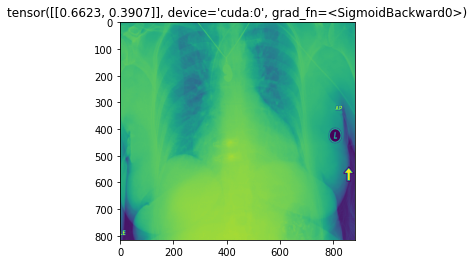

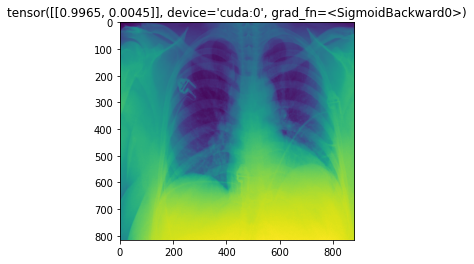

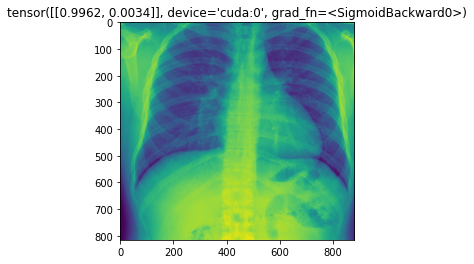

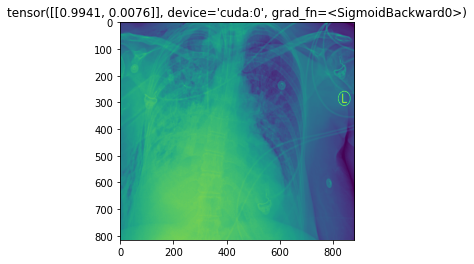

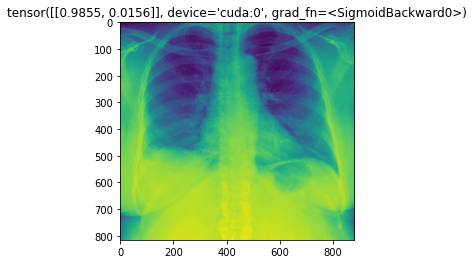

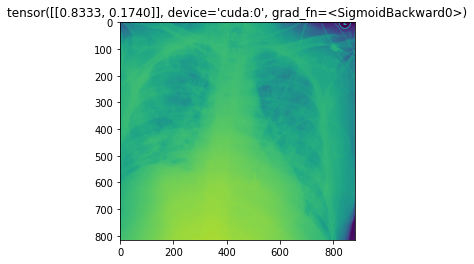

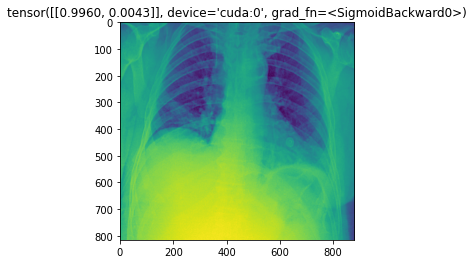

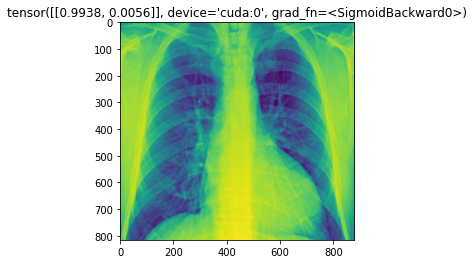

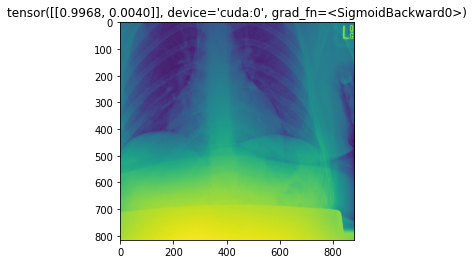

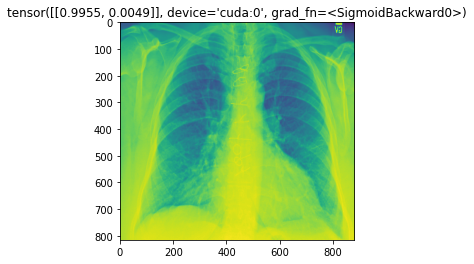

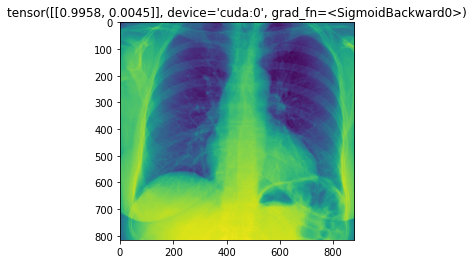

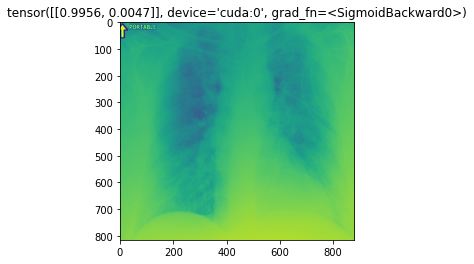

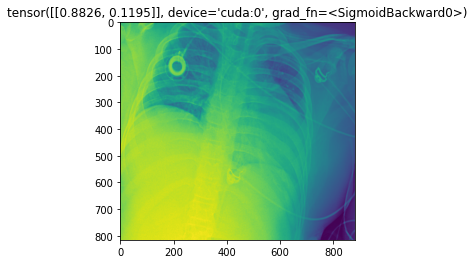

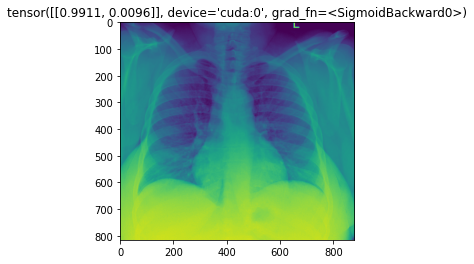

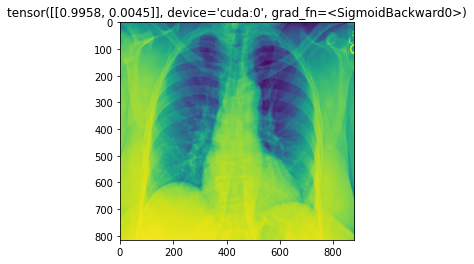

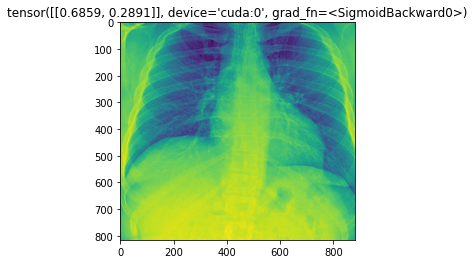

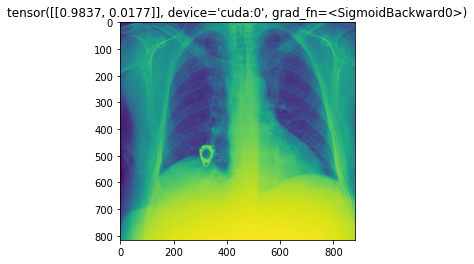

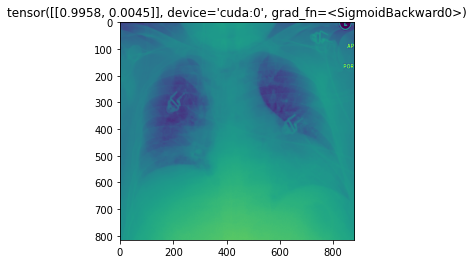

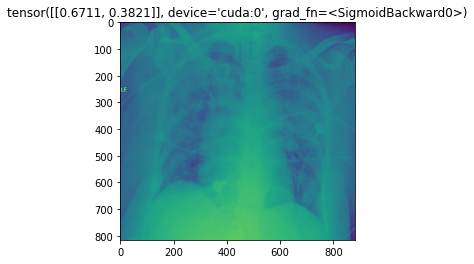

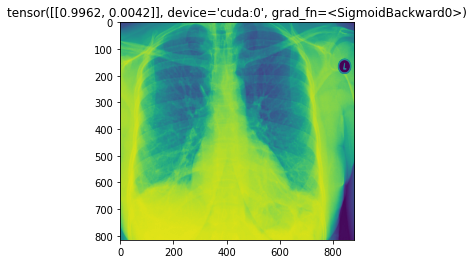

In [ ]:
for i in range(int(0.9*p),int(0.93*p)):
  NofindXcardio22.eval()
  xt=torch.Tensor(plt.imread(pos_val['path'][i])[144:960,80:960]).cuda()
  if xt.shape==(816,880):
    xt = xt.reshape(1,1,816,880)
  else:  
    xt = xt[:,:,0].reshape(1,1,816,880)
  finding=NofindXcardio22(xt,torch.Tensor([pos_val['Patient Age'][i],pos_val['Gender'][i],pos_val['position'][i]]).reshape(1,3).cuda())
  if finding[0][0]>finding[0][1]:
    plt.figure()
    plt.imshow(plt.imread(pos_val['path'][i])[144:960,80:960])
    plt.title(str(finding))

**False positive images**

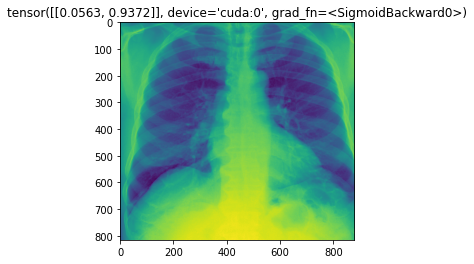

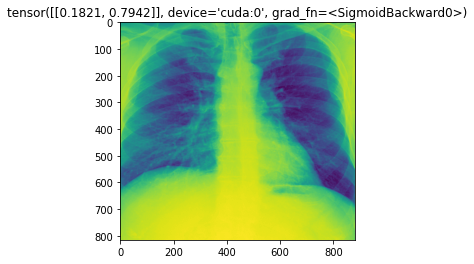

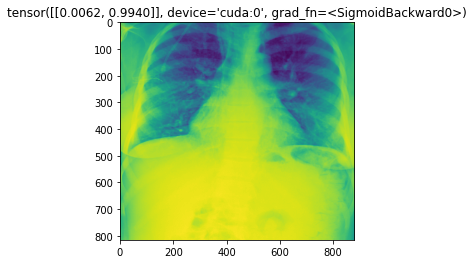

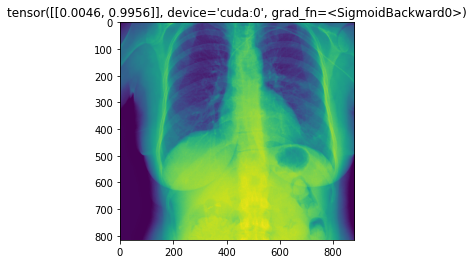

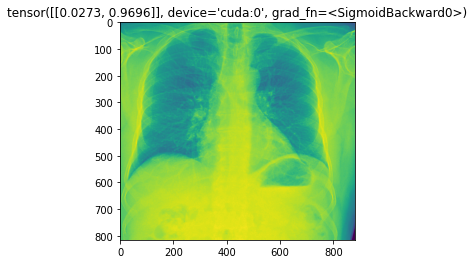

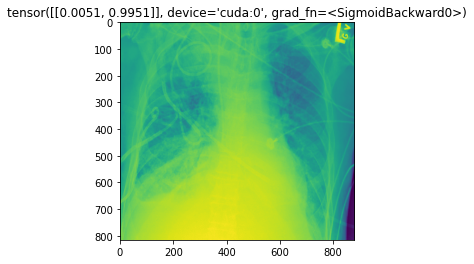

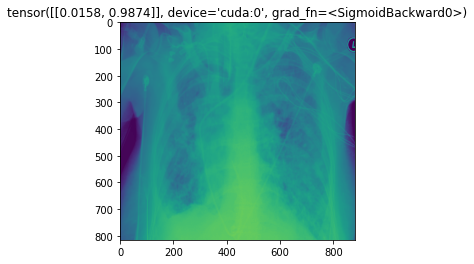

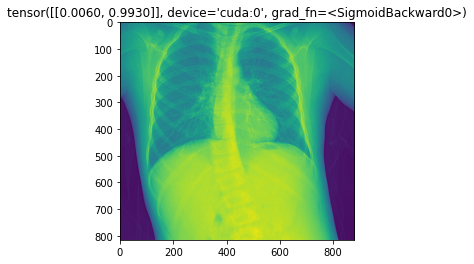

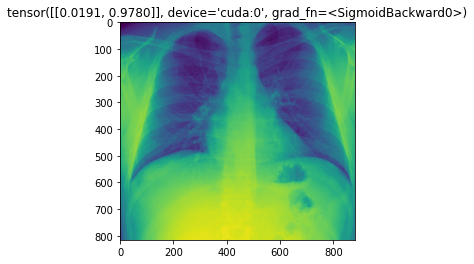

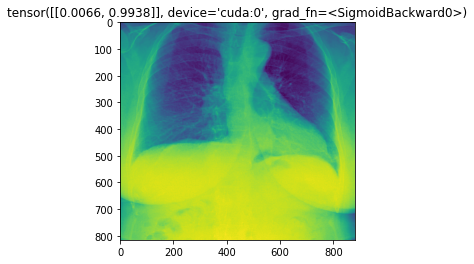

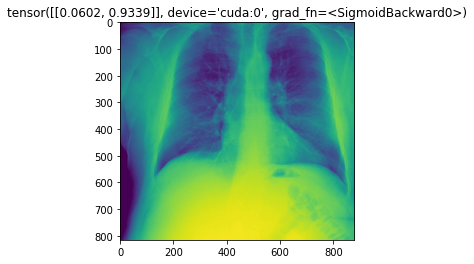

In [ ]:
for i in range(int(0.9*n),int(0.901*n)):
  NofindXcardio22.eval()
  xt=torch.Tensor(plt.imread(neg_val['path'][i])[144:960,80:960]).cuda()
  if xt.shape==(816,880):
    xt = xt.reshape(1,1,816,880)
  else:  
    xt = xt[:,:,0].reshape(1,1,816,880)
  finding=NofindXcardio22(xt,torch.Tensor([neg_val['Patient Age'][i],neg_val['Gender'][i],neg_val['position'][i]]).reshape(1,3).cuda())
  if finding[0][0]<finding[0][1]:
    plt.figure()
    plt.imshow(plt.imread(neg_val['path'][i])[144:960,80:960])
    plt.title(str(finding))

until now we tried to train the model with full sized cropped image, now we will try to resize it to shape (200,200) and train the model with the resized image size.
unfortunatelly when we tried to train the resized images with our model we got less accurate results than in the models we already trained so we didnt insert it to the report.

From now on we will try to use pretrained models: AlexNet, Resnet18 and VGG16.

# Benchmarks

here we will import real-world state of the art models thatare well known for their good detection accuracy in many test cases and some, specifically on the NIH dataset

## Alexnet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 2) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        #self.block = nn.Linear(4099, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor: #add "vars" argument for variables
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #x = torch.cat((x,vars),1)
        #x = self.block(x)
        return x

In [ ]:
if torch.cuda.is_available():
  alexnet_model = AlexNet().cuda()
else:
  alexnet_model = AlexNet()

In [ ]:
alexnet_model,losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg  = nn_train(alexnet_model,p_train=pos_train,n_train=neg_train[:4000],batch_size=30,learning_rate=0.0002,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=path_saving+'_alexnet2_')

Iter 0. [Val pos Acc 93%] [Val neg Acc 19%] [Train pos Acc 87%,Train neg Acc 20%, Loss 0.693270]
Iter 100. [Val pos Acc 66%] [Val neg Acc 69%] [Train pos Acc 75%,Train neg Acc 74%, Loss 0.509826]
Iter 200. [Val pos Acc 52%] [Val neg Acc 76%] [Train pos Acc 73%,Train neg Acc 82%, Loss 0.555796]
Iter 300. [Val pos Acc 65%] [Val neg Acc 77%] [Train pos Acc 77%,Train neg Acc 76%, Loss 0.541075]
Iter 400. [Val pos Acc 84%] [Val neg Acc 68%] [Train pos Acc 90%,Train neg Acc 72%, Loss 0.386530]
Iter 500. [Val pos Acc 91%] [Val neg Acc 60%] [Train pos Acc 94%,Train neg Acc 63%, Loss 0.406948]
Iter 600. [Val pos Acc 85%] [Val neg Acc 68%] [Train pos Acc 93%,Train neg Acc 69%, Loss 0.366415]
Iter 700. [Val pos Acc 72%] [Val neg Acc 77%] [Train pos Acc 86%,Train neg Acc 82%, Loss 0.385063]
Iter 800. [Val pos Acc 91%] [Val neg Acc 65%] [Train pos Acc 96%,Train neg Acc 69%, Loss 0.393384]
Iter 900. [Val pos Acc 87%] [Val neg Acc 64%] [Train pos Acc 98%,Train neg Acc 71%, Loss 0.274226]
Iter 1000. [

In [ ]:
if torch.cuda.is_available():
  alexnet_model3 = AlexNet().cuda()
else:
  alexnet_model3 = AlexNet()

In [ ]:
alexnet_model3,alex_losses, alex_train_accs_pos, alex_train_accs_neg, alex_val_accs_pos, alex_val_accs_neg  = nn_train(alexnet_model3,p_train=pos_train,n_train=neg_train[:4000],batch_size=50,learning_rate=0.0002,
              weight_decay=0,
              max_iters=800,
              checkpoint_path=path_saving+'_alexnet3_')

Iter 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.693209]
Iter 100. [Val pos Acc 64%] [Val neg Acc 74%] [Train pos Acc 67%,Train neg Acc 77%, Loss 0.629706]
Iter 200. [Val pos Acc 71%] [Val neg Acc 71%] [Train pos Acc 87%,Train neg Acc 70%, Loss 0.506399]
Iter 300. [Val pos Acc 77%] [Val neg Acc 67%] [Train pos Acc 90%,Train neg Acc 73%, Loss 0.455044]
Iter 400. [Val pos Acc 76%] [Val neg Acc 75%] [Train pos Acc 87%,Train neg Acc 73%, Loss 0.508414]
Iter 500. [Val pos Acc 79%] [Val neg Acc 78%] [Train pos Acc 84%,Train neg Acc 75%, Loss 0.389081]
Iter 600. [Val pos Acc 95%] [Val neg Acc 59%] [Train pos Acc 96%,Train neg Acc 59%, Loss 0.406677]
Iter 700. [Val pos Acc 82%] [Val neg Acc 72%] [Train pos Acc 93%,Train neg Acc 73%, Loss 0.362947]
Iter 800. [Val pos Acc 75%] [Val neg Acc 81%] [Train pos Acc 87%,Train neg Acc 83%, Loss 0.482742]


In [ ]:
alexnet_model31.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_alexnet3_900'))
alexnet_model31,alex_losses2, alex_train_accs_pos2, alex_train_accs_neg2, alex_val_accs_pos2, alex_val_accs_neg2  = nn_train(alexnet_model3,p_train=pos_train,n_train=neg_train[:4000],batch_size=50,learning_rate=0.00005,
              weight_decay=0,
              max_iters=1300,
              checkpoint_path=path_saving+'_alexnet3_')

Iter 900. [Val pos Acc 69%] [Val neg Acc 83%] [Train pos Acc 86%,Train neg Acc 85%, Loss 0.273161]
Iter 1000. [Val pos Acc 82%] [Val neg Acc 73%] [Train pos Acc 95%,Train neg Acc 79%, Loss 0.328978]


KeyboardInterrupt: ignored

In [ ]:
alexnet_model.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_alexnet_1200'))
alexnet_model,losses2, train_accs_pos2, train_accs_neg2, val_accs_pos2, val_accs_neg2  = nn_train(alexnet_model,pos_train=pos_train,neg_train=neg_train[:4000],batch_size=30,learning_rate=0.00005,
              weight_decay=0,
              max_iters=1500,
              checkpoint_path=path_saving+'_alexnet_')

Iter 1100. [Val pos Acc 86%] [Val neg Acc 79%] [Train pos Acc 89%,Train neg Acc 82%, Loss 0.388061]
Iter 1200. [Val pos Acc 84%] [Val neg Acc 84%] [Train pos Acc 83%,Train neg Acc 85%, Loss 0.318435]
Iter 1300. [Val pos Acc 89%] [Val neg Acc 78%] [Train pos Acc 91%,Train neg Acc 82%, Loss 0.328739]
Iter 1400. [Val pos Acc 80%] [Val neg Acc 86%] [Train pos Acc 81%,Train neg Acc 89%, Loss 0.393724]
Iter 1500. [Val pos Acc 86%] [Val neg Acc 80%] [Train pos Acc 89%,Train neg Acc 87%, Loss 0.379396]


In [ ]:
if torch.cuda.is_available():
  resnet18_model = torchvision.models.resnet18(num_classes=2).cuda()
else:
  resnet18_model = torchvision.models.resnet18(num_classes=2)

### performance and insights
in the architecture above we see a high accuracy results, and we hyperparameters in our model

## Resnet 

In [ ]:
resnet18_model,res_losses, res_train_accs_pos, res_train_accs_neg, res_val_accs_pos, res_val_accs_neg  = nn_train(resnet18_model,p_train=pos_train,n_train=neg_train[:2500],p_val=pos_val,n_val=neg_val,batch_size=30,learning_rate=0.01,
              weight_decay=0,
              max_iters=1200,
              checkpoint_path=path_saving+'_resnet2_')

Iter 0. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.745943]
Iter 100. [Val pos Acc 2%] [Val neg Acc 80%] [Train pos Acc 19%,Train neg Acc 79%, Loss 0.571930]
Iter 200. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.550619]
Iter 300. [Val pos Acc 49%] [Val neg Acc 13%] [Train pos Acc 89%,Train neg Acc 15%, Loss 0.505856]
Iter 400. [Val pos Acc 69%] [Val neg Acc 2%] [Train pos Acc 97%,Train neg Acc 3%, Loss 0.565627]
Iter 500. [Val pos Acc 4%] [Val neg Acc 82%] [Train pos Acc 31%,Train neg Acc 82%, Loss 0.643874]


In [ ]:
resnet18_model,res_losses, res_train_accs_pos, res_train_accs_neg, res_val_accs_pos, res_val_accs_neg  = nn_train(resnet18_model,p_train=pos_train,n_train=neg_train[:2400],batch_size=40,learning_rate=0.001,
              weight_decay=0.0001,
              max_iters=1200,
              checkpoint_path=path_saving+'_resnet2_')

Iter 600. [Val pos Acc 11%] [Val neg Acc 77%] [Train pos Acc 41%,Train neg Acc 67%, Loss 0.416406]
Iter 700. [Val pos Acc 6%] [Val neg Acc 76%] [Train pos Acc 31%,Train neg Acc 77%, Loss 0.443934]
Iter 800. [Val pos Acc 9%] [Val neg Acc 75%] [Train pos Acc 37%,Train neg Acc 73%, Loss 0.537489]
Iter 900. [Val pos Acc 8%] [Val neg Acc 76%] [Train pos Acc 30%,Train neg Acc 73%, Loss 0.478674]
Iter 1000. [Val pos Acc 29%] [Val neg Acc 27%] [Train pos Acc 77%,Train neg Acc 26%, Loss 0.436755]
Iter 1100. [Val pos Acc 47%] [Val neg Acc 14%] [Train pos Acc 89%,Train neg Acc 15%, Loss 0.539475]
Iter 1200. [Val pos Acc 5%] [Val neg Acc 87%] [Train pos Acc 18%,Train neg Acc 87%, Loss 0.458038]


In [ ]:
resnet18_model,res_losses2, res_train_accs_pos2, res_train_accs_neg2, res_val_accs_pos2, res_val_accs_neg2  = nn_train(resnet18_model,p_train=pos_train,n_train=neg_train[:2400],batch_size=70,learning_rate=0.001,
              weight_decay=0.0001,
              max_iters=1600,
              checkpoint_path=path_saving+'_resnet2_')

Iter 1300. [Val pos Acc 19%] [Val neg Acc 56%] [Train pos Acc 58%,Train neg Acc 53%, Loss 0.365665]
Iter 1400. [Val pos Acc 3%] [Val neg Acc 89%] [Train pos Acc 16%,Train neg Acc 89%, Loss 0.331715]
Iter 1500. [Val pos Acc 11%] [Val neg Acc 81%] [Train pos Acc 25%,Train neg Acc 82%, Loss 0.365815]
Iter 1600. [Val pos Acc 16%] [Val neg Acc 67%] [Train pos Acc 42%,Train neg Acc 63%, Loss 0.318290]


In [ ]:
resnet18_model,res_losses3, res_train_accs_pos3, res_train_accs_neg3, res_val_accs_pos3, res_val_accs_neg3  = nn_train(resnet18_model,p_train=pos_train,n_train=neg_train[:2400],batch_size=70,learning_rate=0.001,
              weight_decay=0.0001,
              max_iters=2300,
              checkpoint_path=path_saving+'_resnet2_')

Iter 1700. [Val pos Acc 61%] [Val neg Acc 74%] [Train pos Acc 93%,Train neg Acc 94%, Loss 0.219982]
Iter 1800. [Val pos Acc 61%] [Val neg Acc 73%] [Train pos Acc 92%,Train neg Acc 88%, Loss 0.206551]
Iter 1900. [Val pos Acc 61%] [Val neg Acc 72%] [Train pos Acc 96%,Train neg Acc 92%, Loss 0.187267]
Iter 2000. [Val pos Acc 60%] [Val neg Acc 76%] [Train pos Acc 91%,Train neg Acc 93%, Loss 0.198882]
Iter 2100. [Val pos Acc 61%] [Val neg Acc 74%] [Train pos Acc 93%,Train neg Acc 94%, Loss 0.260913]
Iter 2200. [Val pos Acc 59%] [Val neg Acc 75%] [Train pos Acc 95%,Train neg Acc 93%, Loss 0.228538]
Iter 2300. [Val pos Acc 59%] [Val neg Acc 74%] [Train pos Acc 92%,Train neg Acc 94%, Loss 0.162955]


In [ ]:
if torch.cuda.is_available():
  vgg16_model = torchvision.models.vgg16(num_classes=2).cuda()
else:
  vgg16_model = torchvision.models.vgg16(num_classes=2)

In [ ]:
vgg16_model,vgg_losses, vgg_train_accs_pos, vgg_train_accs_neg, vgg_val_accs_pos, vgg_val_accs_neg  = nn_train(vgg16_model,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=80,learning_rate=0.001,
              weight_decay=0,
              max_iters=1500,
              checkpoint_path=path_saving+'_VGG16_')

Iter 0. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.691487]
Iter 100. [Val pos Acc 67%] [Val neg Acc 62%] [Train pos Acc 72%,Train neg Acc 62%, Loss 0.690365]
Iter 200. [Val pos Acc 74%] [Val neg Acc 52%] [Train pos Acc 82%,Train neg Acc 54%, Loss 0.561248]
Iter 300. [Val pos Acc 48%] [Val neg Acc 78%] [Train pos Acc 63%,Train neg Acc 77%, Loss 0.614700]
Iter 400. [Val pos Acc 82%] [Val neg Acc 56%] [Train pos Acc 91%,Train neg Acc 57%, Loss 0.570075]
Iter 500. [Val pos Acc 49%] [Val neg Acc 76%] [Train pos Acc 72%,Train neg Acc 79%, Loss 0.528418]
Iter 600. [Val pos Acc 74%] [Val neg Acc 69%] [Train pos Acc 87%,Train neg Acc 66%, Loss 0.592636]
Iter 700. [Val pos Acc 86%] [Val neg Acc 58%] [Train pos Acc 93%,Train neg Acc 56%, Loss 0.634824]
Iter 800. [Val pos Acc 46%] [Val neg Acc 87%] [Train pos Acc 72%,Train neg Acc 84%, Loss 0.486805]
Iter 900. [Val pos Acc 58%] [Val neg Acc 76%] [Train pos Acc 85%,Train neg Acc 75%, Loss 0.375474]
Iter 1000. [

In [ ]:
vgg16_model,vgg_losses2, vgg_train_accs_pos2, vgg_train_accs_neg2, vgg_val_accs_pos2, vgg_val_accs_neg2  = nn_train(vgg16_model,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=100,learning_rate=0.001,
              weight_decay=0,
              max_iters=4000,
              checkpoint_path=path_saving+'_VGG16_')

Iter 1600. [Val pos Acc 61%] [Val neg Acc 74%] [Train pos Acc 86%,Train neg Acc 78%, Loss 0.556837]
Iter 1700. [Val pos Acc 51%] [Val neg Acc 79%] [Train pos Acc 83%,Train neg Acc 82%, Loss 0.347607]
Iter 1800. [Val pos Acc 41%] [Val neg Acc 81%] [Train pos Acc 82%,Train neg Acc 85%, Loss 0.392323]
Iter 1900. [Val pos Acc 53%] [Val neg Acc 81%] [Train pos Acc 85%,Train neg Acc 83%, Loss 0.368752]
Iter 2000. [Val pos Acc 41%] [Val neg Acc 82%] [Train pos Acc 81%,Train neg Acc 85%, Loss 0.455179]
Iter 2100. [Val pos Acc 39%] [Val neg Acc 83%] [Train pos Acc 79%,Train neg Acc 86%, Loss 0.352728]
Iter 2200. [Val pos Acc 69%] [Val neg Acc 70%] [Train pos Acc 89%,Train neg Acc 74%, Loss 0.383778]
Iter 2300. [Val pos Acc 63%] [Val neg Acc 71%] [Train pos Acc 88%,Train neg Acc 78%, Loss 0.342160]
Iter 2400. [Val pos Acc 43%] [Val neg Acc 78%] [Train pos Acc 82%,Train neg Acc 87%, Loss 0.376327]
Iter 2500. [Val pos Acc 72%] [Val neg Acc 68%] [Train pos Acc 90%,Train neg Acc 75%, Loss 0.447656]


Text(0.5, 1.0, 'val_acc_neg')

<Figure size 432x288 with 0 Axes>

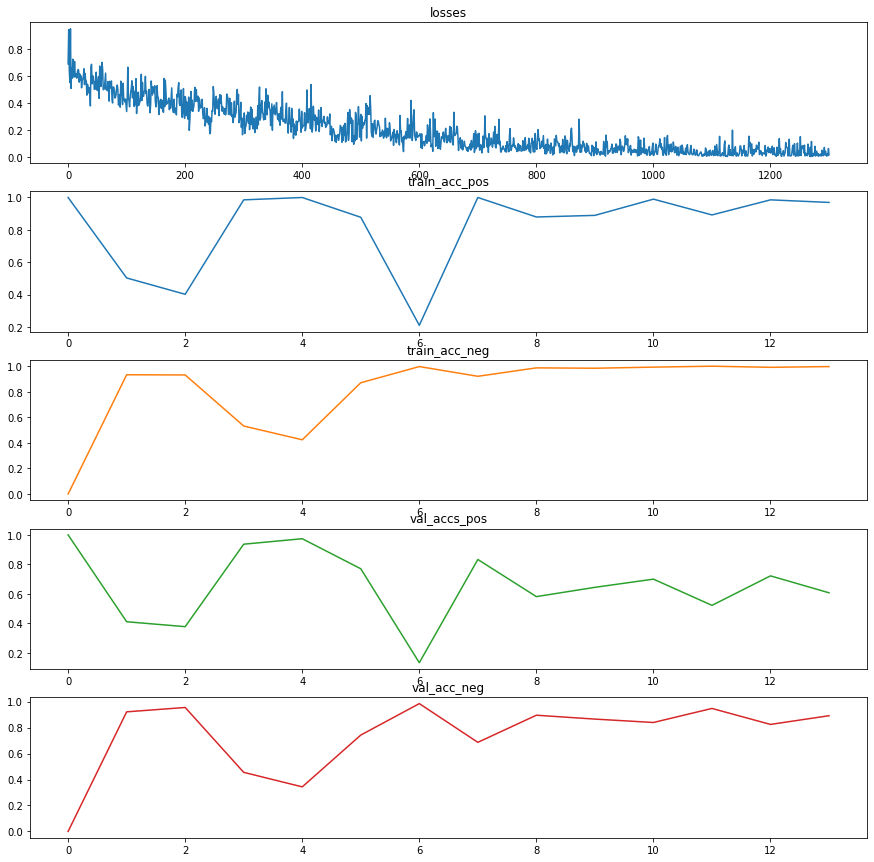

In [ ]:
from numpy.core.function_base import linspace

def plot_analisys(model, history)
  plt.figure()
  
  # devide to sections
  res_train_accs_pos,res_train_accs_neg, res_val_accs_pos, res_val_accs_neg = history
  N = range(len(res_losses))

  fig, axs = plt.subplots(5,figsize=(15, 15))

  axs[0].plot(N, [30*res_losses[i] for i in N])
  axs[0].set_title('losses')

  N = range(len(res_train_accs_pos))
  axs[1].plot(N, res_train_accs_pos)
  axs[1].set_title('train positive accuracy ')
  axs[2].plot(N, res_train_accs_neg,'tab:orange')
  axs[2].set_title('train negative accuracy')
  axs[3].plot(N, res_val_accs_pos, 'tab:green')
  axs[3].set_title('validation positive accuracy')
  axs[4].plot(N, res_val_accs_neg, 'tab:red')
  axs[4].set_title('validation negative accuracy')

  

In [ ]:
#best_resnet18_model =torchvision.models.resnet18(num_classes=2).cuda()
#best_resnet18_model.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_resnet_900'))
#best_resnet18_model.eval()
test_pos_res, test_neg_res = get_accuracy(resnet18_model,pos_val,neg_val,10)
print(f'positive test accuracy: {test_pos_res*100}')
print(f'negative test accuracy: {test_neg_res*100}')

positive test accuracy: 60.74074074074074
negative test accuracy: 89.17910447761194
